In [1]:
import numpy as np 
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image
import gdown
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns

In [2]:
file_path = "test.zip"
output = file_path

if not os.path.exists("Face Emotions Images/"):
    gdown.download("https://drive.google.com/uc?id=1QK-WIVObJWHtdQfoigVCpbaY6YYaZIPk", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)

In [3]:
#Data augmentation for disgust category
#import imutils

#db_path = "Face Emotions Images/disgust/"
#for n in range(len(disgust)):
#    cv2.imwrite("C:/Users/Nicho/OneDrive/Desktop/UNI/MAGISTRALE/Visione Artificiale/FER-and-GR-Project/Face Emotions Images/disgust/d{}.png".format(n),cv2.flip(disgust[n],1))

#for n in range(len(disgust)):
#    cv2.imwrite("C:/Users/Nicho/OneDrive/Desktop/UNI/MAGISTRALE/Visione Artificiale/FER-and-GR-Project/Face Emotions Images/disgust/rl{}.png".format(n),imutils.rotate(disgust[10], angle=20))

#for n in range(len(disgust)):
#    cv2.imwrite("C:/Users/Nicho/OneDrive/Desktop/UNI/MAGISTRALE/Visione Artificiale/FER-and-GR-Project/Face Emotions Images/disgust/rr{}.png".format(n),imutils.rotate(disgust[10], angle=-20))


In [4]:
db_path = "Face Emotions Images/"
batch_size = 64
num_classes = 7
img_height = 224
img_width = 224

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(db_path,
                                                               validation_split=0.20,
                                                               subset="training",
                                                               seed=123456,
                                                               label_mode = 'int',
                                                               color_mode='grayscale',
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(db_path,
                                                               validation_split=0.20,
                                                               subset="validation",
                                                               seed=123456,
                                                               label_mode = 'int',
                                                               color_mode='grayscale',
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)


Found 69314 files belonging to 7 classes.
Using 55452 files for training.
Found 69314 files belonging to 7 classes.
Using 13862 files for validation.


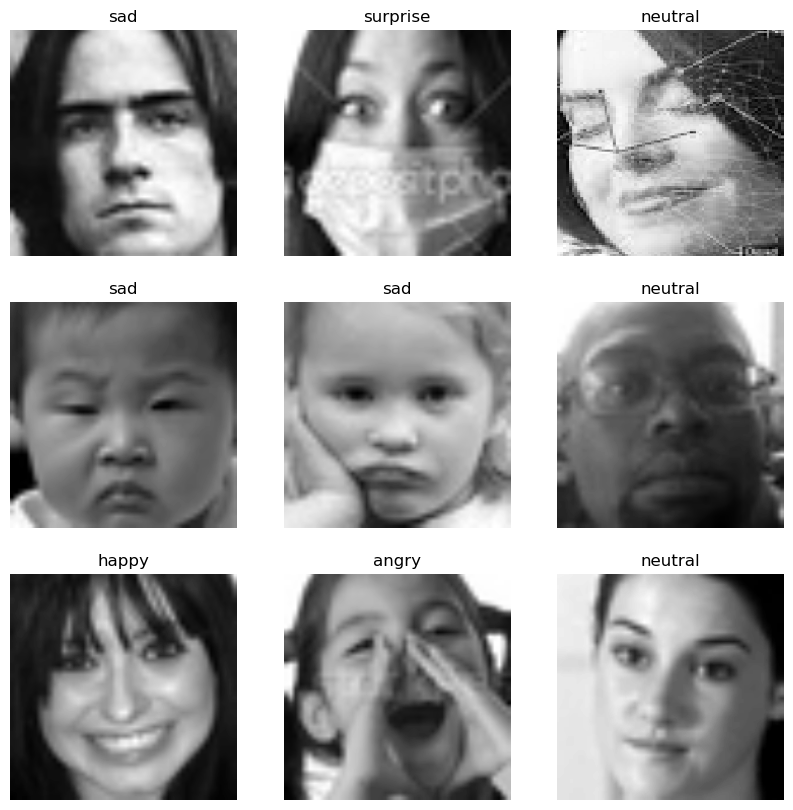

In [30]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        ax.imshow(images[i].numpy().astype("uint8")[:,:,0], cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [26]:
# Build the Model

model = Sequential([
                  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,1)),
                  layers.Conv2D(32, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(64, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Conv2D(128, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Dropout(0.2),
                  layers.Conv2D(256, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Dropout(0.2),
                  layers.Conv2D(512, 3, padding='same', activation='relu'),
                  layers.MaxPooling2D(),
                  layers.Dropout(0.2),
                  layers.Flatten(),
                  layers.Dense(256, activation='relu'),
                  layers.Dropout(0.2),  
                  layers.Dense(128, activation = 'relu'),
                  layers.Dropout(0.2),
                  layers.Dense(num_classes, activation = 'sigmoid')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  mode='auto',
                                                  restore_best_weights=True
                                                 )
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 28, 28, 128)      

In [27]:
epochs = 50
history = model.fit(train_ds, validation_data = val_ds, epochs = epochs, batch_size = batch_size, 
                    verbose = 2, callbacks=[early_stopping])

Epoch 1/50
955/955 - 88s - loss: 1.5024 - accuracy: 0.4141 - val_loss: 1.2452 - val_accuracy: 0.5168
Epoch 2/50
955/955 - 86s - loss: 1.2061 - accuracy: 0.5406 - val_loss: 1.0748 - val_accuracy: 0.5928
Epoch 3/50
955/955 - 85s - loss: 1.0579 - accuracy: 0.5994 - val_loss: 0.9835 - val_accuracy: 0.6323
Epoch 4/50
955/955 - 85s - loss: 0.9292 - accuracy: 0.6503 - val_loss: 0.9149 - val_accuracy: 0.6597
Epoch 5/50
955/955 - 86s - loss: 0.8180 - accuracy: 0.6955 - val_loss: 0.8792 - val_accuracy: 0.6867
Epoch 6/50
955/955 - 86s - loss: 0.7236 - accuracy: 0.7305 - val_loss: 0.8112 - val_accuracy: 0.7133
Epoch 7/50
955/955 - 85s - loss: 0.6337 - accuracy: 0.7664 - val_loss: 0.7549 - val_accuracy: 0.7379
Epoch 8/50
955/955 - 89s - loss: 0.5760 - accuracy: 0.7887 - val_loss: 0.7364 - val_accuracy: 0.7533
Epoch 9/50
955/955 - 85s - loss: 0.5171 - accuracy: 0.8109 - val_loss: 0.7079 - val_accuracy: 0.7679
Epoch 10/50
955/955 - 85s - loss: 0.4778 - accuracy: 0.8271 - val_loss: 0.6644 - val_accura

In [107]:
model_acc = model.evaluate(val_ds)[1]
model_acc

239/239 [==============================] - ETA: 1:41:02 - loss: 0.8768 - accuracy: 0.796 - ETA: 1:07 - loss: 0.5092 - accuracy: 0.8750  - ETA: 42s - loss: 0.4976 - accuracy: 0.8802 - ETA: 33s - loss: 0.4614 - accuracy: 0.882 - ETA: 28s - loss: 0.4863 - accuracy: 0.890 - ETA: 25s - loss: 0.4814 - accuracy: 0.885 - ETA: 4:31 - loss: 0.4951 - accuracy: 0.87 - ETA: 3:55 - loss: 0.5043 - accuracy: 0.87 - ETA: 3:27 - loss: 0.5022 - accuracy: 0.86 - ETA: 3:05 - loss: 0.5065 - accuracy: 0.86 - ETA: 2:48 - loss: 0.4852 - accuracy: 0.87 - ETA: 2:33 - loss: 0.4889 - accuracy: 0.87 - ETA: 2:21 - loss: 0.4972 - accuracy: 0.86 - ETA: 2:11 - loss: 0.4992 - accuracy: 0.86 - ETA: 2:02 - loss: 0.4836 - accuracy: 0.86 - ETA: 1:55 - loss: 0.5008 - accuracy: 0.86 - ETA: 1:49 - loss: 0.4999 - accuracy: 0.86 - ETA: 1:43 - loss: 0.4904 - accuracy: 0.86 - ETA: 2:54 - loss: 0.4794 - accuracy: 0.87 - ETA: 2:45 - loss: 0.4828 - accuracy: 0.86 - ETA: 2:29 - loss: 0.4943 - accuracy: 0.86 - ETA: 2:22 - loss: 0.4821 

0.8563387393951416

In [108]:
model.save("Emotions Model")

INFO:tensorflow:Assets written to: Emotions Model\assets


In [45]:
emotions_model = keras.models.load_model('Emotions Model/')
testData = tf.keras.preprocessing.image_dataset_from_directory(
    "Test Set/Emotions",
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    seed=123456,
    image_size=(img_height,img_width),
    batch_size=1000)


predictions = np.array([])
labels =  np.array([])
for x, y in testData:
    predictions = np.concatenate([predictions, np.argmax(emotions_model.predict(x), axis = -1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

Found 433 files belonging to 7 classes.
14/14 [==============================] - 2s 167ms/step


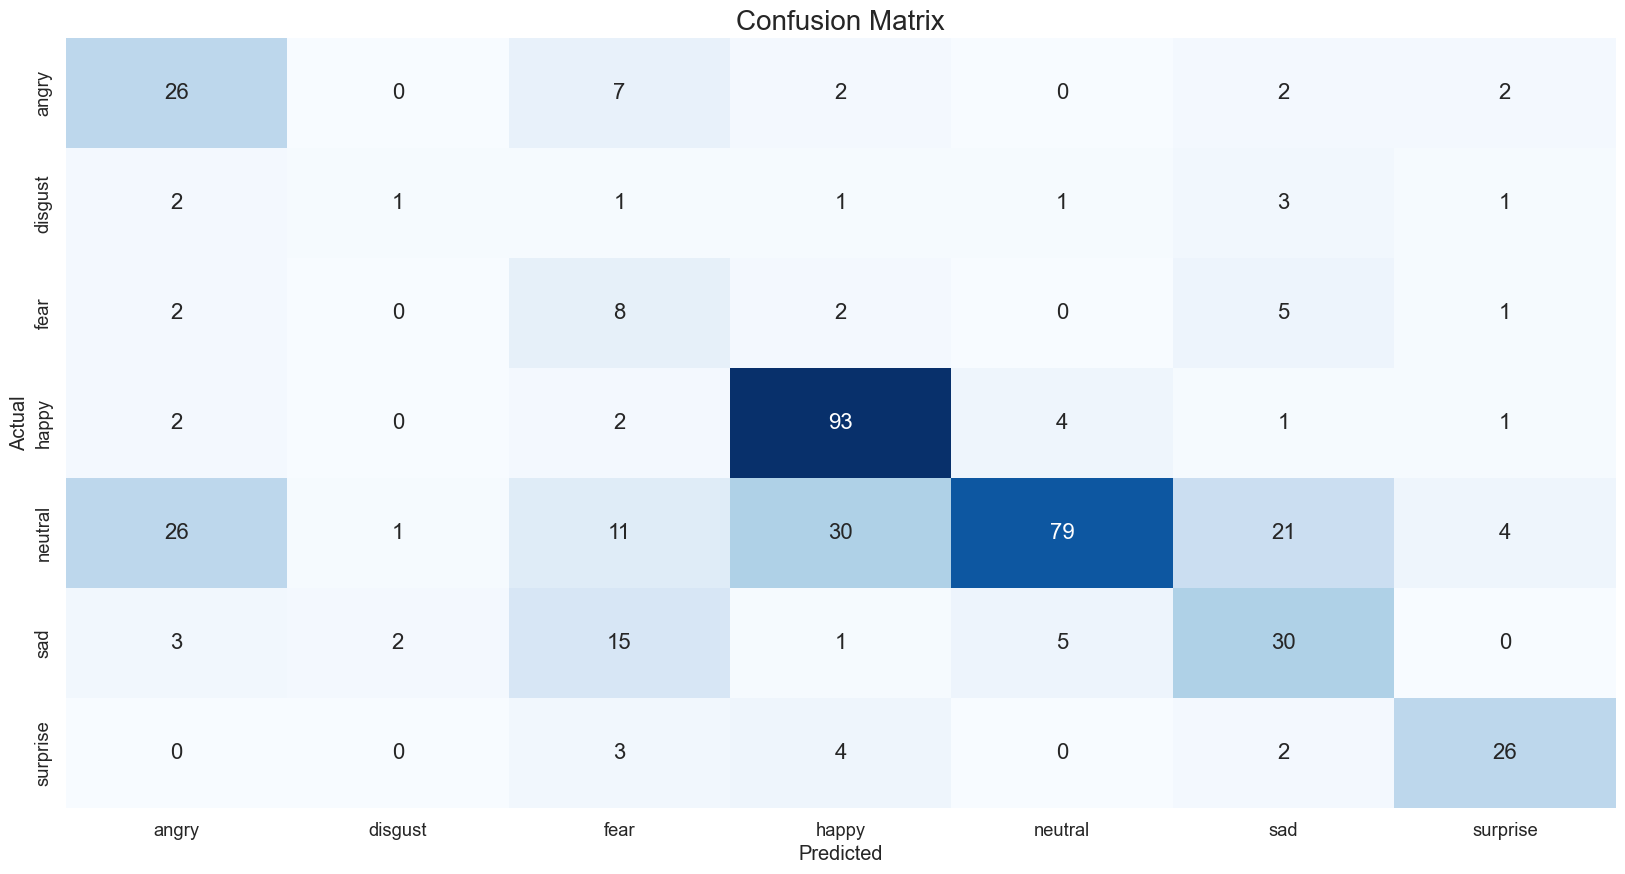

In [44]:
cm_data = confusion_matrix(labels , predictions)
cm = pd.DataFrame(cm_data, columns=class_names, index = class_names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [47]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

         0.0       0.43      0.67      0.52        39
         1.0       0.25      0.10      0.14        10
         2.0       0.17      0.44      0.25        18
         3.0       0.70      0.90      0.79       103
         4.0       0.89      0.46      0.61       172
         5.0       0.47      0.54      0.50        56
         6.0       0.74      0.74      0.74        35

    accuracy                           0.61       433
   macro avg       0.52      0.55      0.51       433
weighted avg       0.69      0.61      0.61       433

